This notebook is an adapted version of the distance 3 "hook errors" notebook. It sets up the distance 5 rotated surface code, generates the ZX diagram, and provides scaffolding for hook error propagation analysis.

Places where you must manually enter data after inspecting the printed / drawn graph are clearly marked with TODO comments.

In [47]:
from error_prop_tools import *
import pyzx as zx
import numpy as np
import scipy as sp
import sympy as sy
import random
import matplotlib.pyplot as plt
from fractions import Fraction
import quimb.tensor as qtn
import pprint as pprint

--- Generated Grid Map for d=5 ---
[[0, 0, 'X0', 0, 0, 0, 'X1', 0, 0, 0, 0],
 [0, 'd0', 0, 'd1', 0, 'd2', 0, 'd3', 0, 'd4', 0],
 [0, 0, 'Z0', 0, 'X2', 0, 'Z1', 0, 'X3', 0, 'Z2'],
 [0, 'd5', 0, 'd6', 0, 'd7', 0, 'd8', 0, 'd9', 0],
 ['Z3', 0, 'X4', 0, 'Z4', 0, 'X5', 0, 'Z5', 0, 0],
 [0, 'd10', 0, 'd11', 0, 'd12', 0, 'd13', 0, 'd14', 0],
 [0, 0, 'Z6', 0, 'X6', 0, 'Z7', 0, 'X7', 0, 'Z8'],
 [0, 'd15', 0, 'd16', 0, 'd17', 0, 'd18', 0, 'd19', 0],
 ['Z9', 0, 'X8', 0, 'Z10', 0, 'X9', 0, 'Z11', 0, 0],
 [0, 'd20', 0, 'd21', 0, 'd22', 0, 'd23', 0, 'd24', 0],
 [0, 0, 0, 0, 'X10', 0, 0, 0, 'X11', 0, 0]]


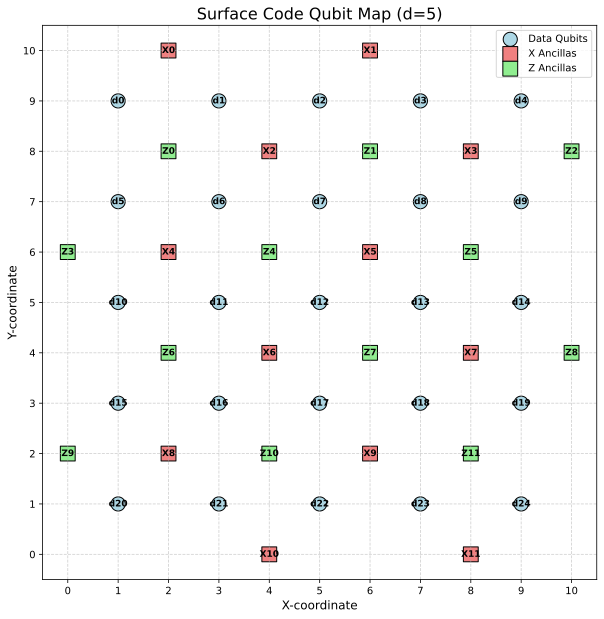


--- PyZX Qubit Ordering (index : (x,y)) ---
 0 : (1, 9)
 1 : (3, 9)
 2 : (5, 9)
 3 : (7, 9)
 4 : (9, 9)
 5 : (1, 7)
 6 : (3, 7)
 7 : (5, 7)
 8 : (7, 7)
 9 : (9, 7)
10 : (1, 5)
11 : (3, 5)
12 : (5, 5)
13 : (7, 5)
14 : (9, 5)
15 : (1, 3)
16 : (3, 3)
17 : (5, 3)
18 : (7, 3)
19 : (9, 3)
20 : (1, 1)
21 : (3, 1)
22 : (5, 1)
23 : (7, 1)
24 : (9, 1)
25 : (2, 10)
26 : (6, 10)
27 : (2, 8)
28 : (4, 8)
29 : (6, 8)
30 : (8, 8)
31 : (10, 8)
32 : (0, 6)
33 : (2, 6)
34 : (4, 6)
35 : (6, 6)
36 : (8, 6)
37 : (2, 4)
38 : (4, 4)
39 : (6, 4)
40 : (8, 4)
41 : (10, 4)
42 : (0, 2)
43 : (2, 2)
44 : (4, 2)
45 : (6, 2)
46 : (8, 2)
47 : (4, 0)
48 : (8, 0)


In [48]:
DISTANCE = 5

# Generate PyZX qubit map (data qubits first, then ancillas sorted)
pyzx_qubit_map, sorted_ancillas = generate_pyzx_and_plot_rotated_code(DISTANCE)
print("\n--- PyZX Qubit Ordering (index : (x,y)) ---")
for idx, coord in enumerate(pyzx_qubit_map):
    print(f"{idx:2d} : {coord}")

In [49]:
# The order list refers to the index within each ancilla's local connected data qubit list.
# You can adjust this list to test different hook mitigation strategies.
order = [1, 2, 3, 0]

# We will build custom_orders automatically for every ancilla with 4 neighbors.
# (Boundary ancillas with &lt;4 neighbors will retain the natural order.)

sc_map_d5 = generate_rotated_surface_code(DISTANCE)
_, ancilla_qubits_d5 = parse_qubit_map(sc_map_d5)

# Reconstruct connectivity to decide which ancillas receive the custom order.
connectivity = {}
for anc in ancilla_qubits_d5:
    r_m, c_m = anc['matrix_coord']
    neigh = find_neighboring_data_qubits(sc_map_d5, r_m, c_m)
    connectivity[anc['label']] = neigh

custom_orders = {}
for label, neigh in connectivity.items():
    if len(neigh) == 4:
        custom_orders[label] = order  # apply chosen permutation

print("Applied custom order to these 4-neighbor ancillas (label: order):")
for k in sorted(custom_orders.keys(), key=lambda s: (s[0], int(s[1:]))):
    print(k, custom_orders[k])

Applied custom order to these 4-neighbor ancillas (label: order):
X2 [1, 2, 3, 0]
X3 [1, 2, 3, 0]
X4 [1, 2, 3, 0]
X5 [1, 2, 3, 0]
X6 [1, 2, 3, 0]
X7 [1, 2, 3, 0]
X8 [1, 2, 3, 0]
X9 [1, 2, 3, 0]
Z0 [1, 2, 3, 0]
Z1 [1, 2, 3, 0]
Z4 [1, 2, 3, 0]
Z5 [1, 2, 3, 0]
Z6 [1, 2, 3, 0]
Z7 [1, 2, 3, 0]
Z10 [1, 2, 3, 0]
Z11 [1, 2, 3, 0]


In [50]:
custom_qasm_string = generate_surface_code_qasm(DISTANCE, custom_cnot_orderings=custom_orders)
print(custom_qasm_string.splitlines()[:20])  # preview first lines

['// Surface Code d=5', 'OPENQASM 2.0;', 'include "qelib1.inc";', 'qreg q[25];', 'qreg a[24];', '', '// Stabilizer for X0 (a[0])', 'h a[0];', 'cx a[0], q[0];', 'cx a[0], q[1];', 'h a[0];', '', '// Stabilizer for X1 (a[1])', 'h a[1];', 'cx a[1], q[2];', 'cx a[1], q[3];', 'h a[1];', '', '// Stabilizer for Z0 (a[2])', '// Using custom CNOT order: [1, 2, 3, 0]']


In [51]:
print("\nBuilding ZX graph...")
g = zx.sqasm(custom_qasm_string, simplify=False)
zx.id_simp(g)
print("Original draw (logical ordering):")
zx.draw(g, True)

# Copy graph for coordinate remap attempt
if len(pyzx_map_rotated) > 0:
    gc = g.copy()
    try:
        gc.map_qubits(pyzx_map_rotated)
        print("\nRemapped qubits using pyzx_map_rotated:")
        zx.draw(gc, True)
    except Exception as e:
        print("Remap failed:", e)
else:
    print("Skipping remap (no manual mapping provided).")


Building ZX graph...
Original draw (logical ordering):


Skipping remap (no manual mapping provided).


In [52]:
# After inspecting the drawn graph(s), define the hooks list.
# Each hook is a tuple: ((vertex_out, vertex_in), 'PauliType') where PauliType in {'X','Z'}
# These vertices correspond to half-edges (output vertex id, its neighbor) where an initial error is injected.
# For distance 3 example: hooks = [((27, 25), 'Z'), ...]
# Leave empty until you inspect g (print(g.vertices()), etc.) and the drawing.

hooks = [
    ((65, 63), 'Z'),  
    ((75, 73), 'X'),
    ((83, 81), 'Z'),
    ((93, 91), 'X'),
    ((119, 117), 'Z'),
    ((111, 109), 'X'),
    ((137, 135), 'Z'),
    ((145, 143), 'Z'),
    ((155, 153), 'Z'),
    ((163, 161), 'Z'),
    ((173, 171), 'X'),
    ((191, 189), 'X'),
    ((199, 197), 'Z'),
    ((209, 207), 'X'),
    ((217, 215), 'Z'),
    
]

if len(hooks) == 0:
    print("No hooks specified yet.")
else:
    print(f"Loaded {len(hooks)} hooks.")

Loaded 15 hooks.


In [53]:
# Identify groups of output vertex indices corresponding to logical Z and X line segments.
# For distance 3, zlines = [[73,74,75], ...] and similarly xlines.
# These depend on vertex numbering after ZX construction.
# Use: print(g.outputs()) and/or inspect g.qubit_map.

zlines = [
    [233, 234, 235, 236, 237],
    [238, 239, 240, 241, 242],
    [243, 244, 245, 246, 247],
    [248, 249, 250, 251, 252],
    [253, 254, 255, 256, 257]
]

xlines = [
    [233, 238, 243, 248, 253],
    [234, 239, 244, 249, 254],
    [235, 240, 245, 250, 255],
    [236, 241, 246, 251, 256],
    [237, 242, 247, 252, 257]
]

if len(zlines) == 0 or len(xlines) == 0:
    print("Logical line definitions pending.")

In [54]:
def number_of_errors(output_errors: dict, zlines: list[list[int]], xlines: list[list[int]]):
    zErrors = 0
    xErrors = 0
    for subArray in zlines:
        tempSum = sum(1 for v in subArray if v in output_errors and output_errors[v] in ('Z','Y'))
        if tempSum >= 2:  # threshold heuristics (same as original: >=2 for d=3)
            zErrors += 1
    for subArray in xlines:
        tempSum = sum(1 for v in subArray if v in output_errors and output_errors[v] in ('X','Y'))
        if tempSum >= 2:
            xErrors += 1
    return zErrors, xErrors

In [55]:
import itertools

permutations = list(itertools.permutations([0, 1, 2, 3]))

# Derive weight-4 stabilizers from connectivity (built earlier)
weight4_labels = [lab for lab, neigh in connectivity.items() if len(neigh) == 4]
weight4_labels.sort(key=lambda s: (s[0], int(s[1:])))
print(f"Weight-4 stabilizers ({len(weight4_labels)}): {weight4_labels}")

max_line_results = {}

# Helper to compute line weight arrays and maxima
def line_weight_arrays(output_errors: dict, zlines: list[list[int]], xlines: list[list[int]]):
    z_weights = [sum(1 for v in line if v in output_errors and output_errors[v] in ('Z', 'Y')) for line in zlines]
    x_weights = [sum(1 for v in line if v in output_errors and output_errors[v] in ('X', 'Y')) for line in xlines]
    return z_weights, x_weights, (max(z_weights) if z_weights else 0), (max(x_weights) if x_weights else 0)

for perm in permutations:
    perm_list = list(perm)
    # Apply permutation ONLY to weight-4 stabilizers (avoid index error on lower-weight checks)
    custom_orders = {lab: perm_list for lab in weight4_labels}

    custom_qasm_string = generate_surface_code_qasm(DISTANCE, custom_cnot_orderings=custom_orders)
    g_perm = zx.sqasm(custom_qasm_string, simplify=False)

    maxZ = 0
    maxX = 0

    for hook in hooks:  # hooks list defined earlier for d=5
        errors_web, _ = PropagatePauliError(g_perm, [hook])
        output_errors = get_output_errors(g_perm, errors_web)
        _, _, mz, mx = line_weight_arrays(output_errors, zlines, xlines)
        maxZ = max(maxZ, mz)
        maxX = max(maxX, mx)

    max_line_results[perm] = (maxZ, maxX)

# Robust if max line weight <=2 (no distance reduction below 3)
robust = sorted([p for p,(mz,mx) in max_line_results.items() if mz <= 2 and mx <= 2])
print("Robust permutations (max line weight <=2 for all tested hooks):")
print(robust)
print(f"Count robust: {len(robust)} / 24")

print("\nFull max-line results (perm -> (maxZ,maxX)):")
for p,res in sorted(max_line_results.items()):
    print(p, res)

print("\nNOTE: The older logical error accumulation cell below is now superseded by this max line weight analysis.")

Weight-4 stabilizers (16): ['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Z0', 'Z1', 'Z4', 'Z5', 'Z6', 'Z7', 'Z10', 'Z11']


KeyboardInterrupt: 